In [1]:
from Simulador import Simulador
from Registrador import Registrador
from simpy import Environment
import networkx as nx
from Cenario.GeradorDeCenarios import GeradorDeCenarios, Cenario
from Variaveis import *
from Roteamento.Roteamento import Roteamento
from Roteamento.RoteamentoBestFit import RoteamentoBestFit
from Roteamento.Roteamento_evitando_nodes_pre_desastre import Roteamento_evitando_nodes_pre_desastre
from Roteamento.RoteamentoBestFit_evitando_nodes_pre_desastre import RoteamentoBestFit_evitando_nodes_pre_desastre
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
env = Environment()
topology = nx.read_weighted_edgelist( "../topology/usa", nodetype=int)


In [3]:
# Criar cenarios

lista_de_roteamento = [ RoteamentoBestFit_evitando_nodes_pre_desastre, Roteamento_evitando_nodes_pre_desastre]
cenario1, cenario2 = GeradorDeCenarios.gerar_cenarios(topology, retorna_lista_de_requisicoes=True, numero_de_requisicoes=NUMERO_DE_REQUISICOES, 
                                                           lista_de_roteamentos_de_desastre = lista_de_roteamento)

with open('cenario/cenarios/cenario1.pkl', 'wb') as file:
    pickle.dump(cenario1, file) 
with open('cenario/cenarios/cenario2.pkl', 'wb') as file:
    pickle.dump(cenario2, file)


9
9
11
9
12
12
10
9
15
9
9
8
16
17
10
14
16
17
12
11
12
9
9
11
12
10
9
14
9
10
13
15
12
10
12
10
12
11
11
12
9
12
13
9
11
9


In [4]:
#salvar cenarios
cenario1: Cenario = pickle.load(open('cenario/cenarios/cenario1.pkl', 'rb'))
cenario2: Cenario = pickle.load(open('cenario/cenarios/cenario2.pkl', 'rb'))

In [5]:
cenario1.desastre.duration

185.48515599258363

In [6]:
cenario1.desastre.eventos_nao_iniciados

[{'tipo': 'link', 'src': 9, 'dst': 7, 'start_time': 0},
 {'tipo': 'node', 'node': 9, 'start_time': 19},
 {'tipo': 'link', 'src': 9, 'dst': 12, 'start_time': 75},
 {'tipo': 'link', 'src': 9, 'dst': 6, 'start_time': 87},
 {'tipo': 'link', 'src': 9, 'dst': 10, 'start_time': 141}]

In [7]:
cenario1.desastre.start + 110

632.4851266822853

In [8]:
cenario1.desastre.duration

185.48515599258363

In [9]:
#roda cenario1
simulador :Simulador  = Simulador(env=env, topology=topology, status_logger=True, cenario=cenario1)
simulador.run()
dataframe_cenario1 = simulador.salvar_dataframe("_out/resultados/df_cenario1")



10000 requests processed, time : 91.61679471623259
ISP 1 iniciando migração de 9 para 23 no tempo 162.19433469604598
ISP 0 iniciando migração de 9 para 24 no tempo 177.78220377927295
20000 requests processed, time : 181.5217528697045
ISP 4 iniciando migração de 9 para 17 no tempo 192.36550173578723
Status ISP 0, 10.417221107965942% da migração concluída no tempo 195.675056495917
Status ISP 1, 10.271774886551137% da migração concluída no tempo 197.47740043546747
Status ISP 4, 10.010240778416557% da migração concluída no tempo 208.06734383752186
Status ISP 1, 20.377875984609513% da migração concluída no tempo 220.14486173010016
Status ISP 0, 20.30475300705226% da migração concluída no tempo 220.32438979233905
Status ISP 4, 20.413040018731802% da migração concluída no tempo 224.79655843000884
Status ISP 4, 30.42328079714836% da migração concluída no tempo 241.81405818612723
ISP 2 iniciando migração de 9 para 5 no tempo 245.133266105016
Status ISP 0, 30.19228490613858% da migração concluíd

In [10]:

Registrador.reseta_registrador()
env = Environment()
topology = nx.read_weighted_edgelist( "../topology/usa", nodetype=int)


simulador :Simulador  = Simulador(env=env, topology=topology, status_logger=False, cenario=cenario2)
simulador.run()
dataframe_cenario2 = simulador.salvar_dataframe("_out/resultados/df_cenario2")

In [11]:
# Carrega cenario
with open('cenario/cenarios/cenario1.pkl', 'rb') as file:
    cenario1:Cenario = pickle.load(file)

dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")

with open('cenario/cenarios/cenario2.pkl', 'rb') as file:
    cenario2:Cenario = pickle.load(file)

dataframe2: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario2.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_7904\663024727.py:5: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario1.csv")
C:\Users\user\AppData\Local\Temp\ipykernel_7904\663024727.py:10: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe2: pd.DataFrame = pd.read_csv("_out/resultados/df_cenario2.csv")


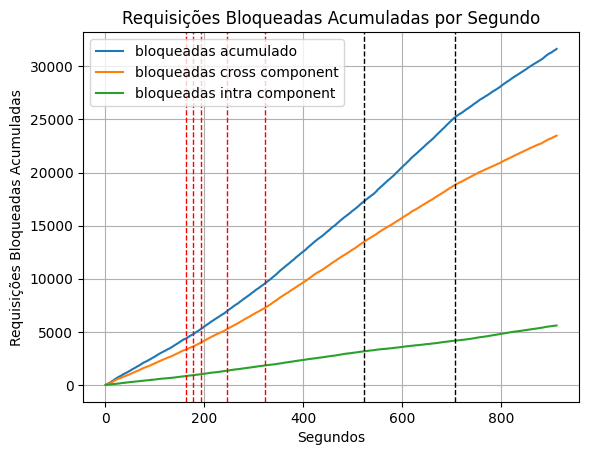

In [53]:
#plota grafico de bloqueadas acumuladas
df_bloqueadas1 = dataframe1[dataframe1["bloqueada"] == True]
df_acumulado_por_segundo1 = df_bloqueadas1.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo1.index, df_acumulado_por_segundo1.values, label=f"bloqueadas acumulado")

#plota grafico de bloqueadas cross componentes acumulada
componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]

filtered_dataframe_bloqueadas = filtered_dataframe[filtered_dataframe["bloqueada"] == True]
df_acumulado_por_segundo2 = filtered_dataframe_bloqueadas.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo2.index, df_acumulado_por_segundo2.values, label=f"bloqueadas cross component")

#plota grafico de bloqueadas intra componentes acumulada
filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]

filtered_dataframe_bloqueadas = filtered_dataframe[filtered_dataframe["bloqueada"] == True]
df_acumulado_por_segundo2 = filtered_dataframe_bloqueadas.groupby('tempo_criacao').size().cumsum()
plt.plot(df_acumulado_por_segundo2.index, df_acumulado_por_segundo2.values, label=f"bloqueadas intra component")


#plota linhas verticais de inicio de migração
tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

#plota inicio e fim do desastre
inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Requisições Bloqueadas Acumuladas')
plt.title('Requisições Bloqueadas Acumuladas por Segundo')

plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

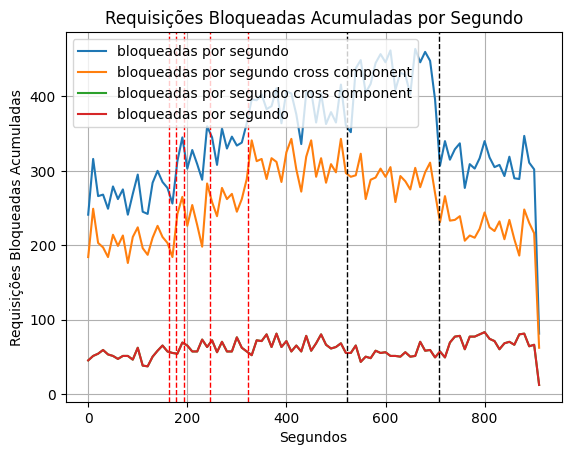

In [ ]:
bucket_size = 10
segundos = (dataframe1['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = dataframe1.groupby(segundos).size()
bloqueadas_por_segundo1 = dataframe1[dataframe1["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo")

# bloqueadas por segundo cross component
componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()
bloqueadas_por_segundo1 = filtered_dataframe[filtered_dataframe["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo cross component")

# bloqueadas por segundo intra component
filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()
bloqueadas_por_segundo1 = filtered_dataframe[filtered_dataframe["bloqueada"] == True].groupby(segundos).size()
plt.plot(bloqueadas_por_segundo1.index, bloqueadas_por_segundo1.values, label="bloqueadas por segundo cross component")

#plota linhas verticais de inicio de migração
tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

#plota inicio e fim do desastre
inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Requisições Bloqueadas Acumuladas')
plt.title('Requisições Bloqueadas Acumuladas por Segundo')

plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

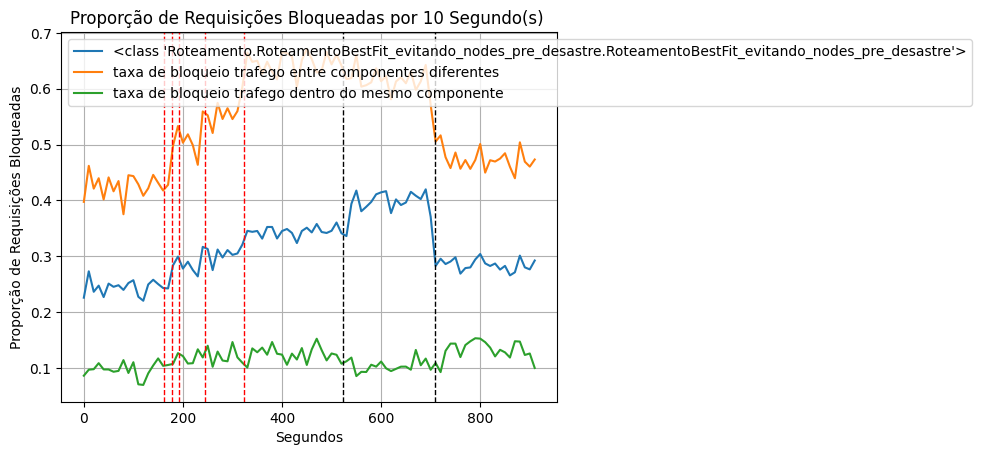

In [39]:
bucket_size = 10
segundos = (dataframe1['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = dataframe1.groupby(segundos).size()
bloqueadas_por_segundo1 = dataframe1[dataframe1["bloqueada"] == True].groupby(segundos).size()
bloqueadas_por_segundo1 = bloqueadas_por_segundo1.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo1 / total_requisicoes_por_segundo1
#plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values)
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label=cenario1.lista_de_ISPs[0].roteamento_desastre)



componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente2))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente1)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "taxa de bloqueio trafego entre componentes diferentes")

filtered_dataframe = dataframe1[
    ((dataframe1['src'].isin(componente1)) & (dataframe1["dst"].isin(componente1))) | 
    ((dataframe1['src'].isin(componente2)) & (dataframe1["dst"].isin(componente2)))
]
segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "taxa de bloqueio trafego dentro do mesmo componente")

# #--------------------------------------------- dataframe2----------------------------------------------
# bucket_size = 10
# segundos = (dataframe2['tempo_criacao'] // bucket_size) * bucket_size
# total_requisicoes_por_segundo1 = dataframe2.groupby(segundos).size()
# bloqueadas_por_segundo1 = dataframe2[dataframe2["bloqueada"] == True].groupby(segundos).size()
# bloqueadas_por_segundo1 = bloqueadas_por_segundo1.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
# proporcao_bloqueadas1 = bloqueadas_por_segundo1 / total_requisicoes_por_segundo1
# #plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values)
# plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label=cenario2.lista_de_ISPs[0].roteamento_desastre)



# componente1 = [i for i in range(1, 9)]
# componente2 = [i for i in range(10, 25)]

# filtered_dataframe = dataframe2[
#     ((dataframe2['src'].isin(componente1)) & (dataframe2["dst"].isin(componente2))) | 
#     ((dataframe2['src'].isin(componente2)) & (dataframe2["dst"].isin(componente1)))
# ]
# segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
# total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

# bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
# bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
# proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
# plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "df2-taxa de bloqueio trafego entre componentes diferentes")

# filtered_dataframe = dataframe2[
#     ((dataframe2['src'].isin(componente1)) & (dataframe2["dst"].isin(componente1))) | 
#     ((dataframe2['src'].isin(componente2)) & (dataframe2["dst"].isin(componente2)))
# ]
# segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
# total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

# bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
# bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
# proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
# plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values, label = "df2-taxa de bloqueio trafego dentro do mesmo componente")


#plota tempos de inicio de migração

tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()  

C:\Users\user\AppData\Local\Temp\ipykernel_7904\3197947864.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'upper left')


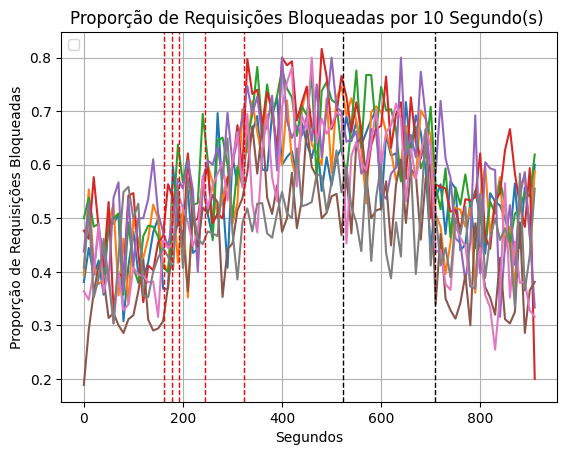

In [44]:

componente1 = [i for i in range(1, 9)]
componente2 = [i for i in range(10, 25)]

for node in componente1:
    componente_oposto = componente1 if node in componente2 else componente2
    filtered_dataframe = dataframe1[
        ((dataframe1['src'] == node) & (dataframe1["dst"].isin(componente_oposto))) | 
        ((dataframe1['src'].isin(componente_oposto)) & (dataframe1["dst"] == node))
        ]
    segundos = (filtered_dataframe['tempo_criacao'] // bucket_size) * bucket_size
    total_requisicoes_por_segundo1 = filtered_dataframe.groupby(segundos).size()

    bloqueadas_por_segundo2 = filtered_dataframe[(filtered_dataframe["bloqueada"] == True)].groupby(segundos).size()
    bloqueadas_por_segundo2 = bloqueadas_por_segundo2.reindex(total_requisicoes_por_segundo1.index, fill_value=0)
    proporcao_bloqueadas1 = bloqueadas_por_segundo2 / total_requisicoes_por_segundo1
    plt.plot(proporcao_bloqueadas1.index, proporcao_bloqueadas1.values)



tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario1.lista_de_ISPs] 

for x in tempos_de_inicio_migracao_ISP:
    plt.axvline(x=x[0], color='red', linestyle='--', linewidth=1)

inicio_desastre = cenario1.desastre.start
fim_desastre = cenario1.desastre.start + cenario1.desastre.duration

#plota inicio e fim do desastre
plt.axvline(x=inicio_desastre, color='black', linestyle='--', linewidth=1)
plt.axvline(x=fim_desastre, color='black', linestyle='--', linewidth=1)


plt.xlabel('Segundos')
plt.ylabel('Proporção de Requisições Bloqueadas')
plt.title(f'Proporção de Requisições Bloqueadas por {bucket_size} Segundo(s) ')
plt.grid(True)
plt.legend(loc = 'upper left')
plt.show()  

In [14]:
node = 1
def calcula_bloqueio_antes_da_migracao(dataframe: pd.DataFrame, node: int, cenario: Cenario):
    tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario.lista_de_ISPs]
    primeiro_tempo = min([x[0] for x in tempos_de_inicio_migracao_ISP])
    numero_de_bloqueadas_antes_migracao = len(dataframe[(dataframe["bloqueada"] == True) &
                                                         ( dataframe["src"] == node) &
                                                         (dataframe["tempo_criacao"] < primeiro_tempo)])
    numero_de_req_antes_migracao = len(dataframe[( dataframe["src"] == node) 
                                                  & (dataframe["tempo_criacao"] < primeiro_tempo)])
    return  numero_de_bloqueadas_antes_migracao / numero_de_req_antes_migracao

def calcula_bloqueio_durante_migracao(dataframe: pd.DataFrame, node: int, cenario: Cenario):
    tempos_de_inicio_migracao_ISP = [ (isp.datacenter.tempo_de_reacao, isp.id) for isp in cenario.lista_de_ISPs]
    primeiro_tempo = min([x[0] for x in tempos_de_inicio_migracao_ISP])
    numero_de_bloqueadas_durante_migracao = len(dataframe[(dataframe["bloqueada"] == True) &
                                                         ( dataframe["src"] == node) &
                                                         (dataframe["tempo_criacao"] > primeiro_tempo) &
                                                         (dataframe["tempo_criacao"] < cenario.desastre.start)])
    
    numero_de_req_durante_migracao = len(dataframe[( dataframe["src"] == node) &
                                                  (dataframe["tempo_criacao"] > primeiro_tempo) &
                                                  (dataframe["tempo_criacao"] < cenario.desastre.start)])
    return  numero_de_bloqueadas_durante_migracao / numero_de_req_durante_migracao


def calcula_bloqueio_durante_desastre(dataframe: pd.DataFrame, node: int, cenario: Cenario):

    numero_de_bloqueadas_durante_migracao = len(dataframe[(dataframe["bloqueada"] == True) &
                                                         ( dataframe["src"] == node) &
                                                         (dataframe["tempo_criacao"] > cenario.desastre.start) &
                                                         (dataframe["tempo_criacao"] < cenario.desastre.start + cenario.desastre.duration)])
    
    numero_de_req_durante_migracao = len(dataframe[( dataframe["src"] == node) &
                                                (dataframe["tempo_criacao"] > cenario.desastre.start) &
                                                (dataframe["tempo_criacao"] < cenario.desastre.start + cenario.desastre.duration)])
    return  numero_de_bloqueadas_durante_migracao / numero_de_req_durante_migracao


In [15]:
calcula_bloqueio_antes_da_migracao(dataframe1, 1, cenario1)

0.28289473684210525

In [16]:
calcula_bloqueio_durante_migracao(dataframe1, 1, cenario1)

0.39070048309178745

In [17]:
def retorna_dict_de_delta_bloqueios_por_node(dataframe1: pd.DataFrame, cenario: Cenario):
    dict_de_delta_bloqueios = {}
    for node in cenario.topology.topology.nodes:
        bloqueio_antes = calcula_bloqueio_antes_da_migracao(dataframe1, node, cenario)
        bloqueio_durante = calcula_bloqueio_durante_migracao(dataframe1, node, cenario)
        dict_de_delta_bloqueios[node]= (bloqueio_durante - bloqueio_antes)
    return dict_de_delta_bloqueios

In [18]:
dict_delta_bloqueios = retorna_dict_de_delta_bloqueios_por_node(dataframe1, cenario1)
dict_delta_bloqueios.pop(cenario1.desastre.list_of_dict_node_per_start_time[0]["node"])

-0.004586548866653106

In [19]:
dict_delta_bloqueios

{1: 0.1078057462496822,
 2: 0.07370024834978106,
 6: 0.11207239459029436,
 3: 0.1328365001706679,
 7: 0.14323729308260014,
 4: 0.11456474429167202,
 5: 0.10989619522198169,
 8: 0.041710021951759824,
 11: 0.10292414827861765,
 10: 0.09121533272537083,
 12: 0.08053545192360015,
 13: 0.06465446641102768,
 14: 0.048876869409589296,
 19: 0.11034125188536956,
 15: 0.08869924793449702,
 16: 0.01164224770135791,
 17: 0.0866308999565838,
 18: 0.07737049015368375,
 20: 0.028245930566845767,
 22: 0.06352846927821854,
 21: 0.04941804691280466,
 23: 0.09403013951888556,
 24: 0.079696785250917}

In [20]:
variancia = float(np.var(list(dict_delta_bloqueios.values())))

In [21]:
min(list(dict_delta_bloqueios.values()))

0.01164224770135791

In [22]:
max(list(dict_delta_bloqueios.values()))

0.14323729308260014

In [23]:

from collections import defaultdict
node_fonte = 1
node_destino = 23
def retorna_criticidade_dos_links_da_topologia(cenario: Cenario):
    links_mais_usados_por_topologia = defaultdict(lambda: defaultdict(int))

    for node_fonte in cenario.topology.topology.nodes:
        criticidade_links = retorna_criticidade_dos_links_de_certo_node(cenario, node_fonte)
        for link, soma_dos_index_do_caminho in criticidade_links.items():
            for index_caminho, valor in soma_dos_index_do_caminho.items():
                links_mais_usados_por_topologia[link][index_caminho] += valor


    for key, value in links_mais_usados_por_topologia.items():
        links_mais_usados_por_topologia[key] = dict(value) 

    return dict(links_mais_usados_por_topologia)


def retorna_criticidade_dos_links_de_certo_node(cenario: Cenario, node_fonte: int):
    
    links_mais_usados_por_node = defaultdict(lambda: defaultdict(int))

    for node_destino in cenario.topology.caminhos_mais_curtos_entre_links[node_fonte]:
        criticidade_links = retorna_criticidade_dos_links_de_certo_node_para_certo_node(cenario, node_fonte, node_destino)
        for link, soma_dos_index_do_caminho in criticidade_links.items():
            for index_caminho, valor in soma_dos_index_do_caminho.items():
                links_mais_usados_por_node[link][index_caminho] += valor


    for key, value in links_mais_usados_por_node.items():
        links_mais_usados_por_node[key] = dict(value) 
        
    return dict(links_mais_usados_por_node)

def retorna_criticidade_dos_links_de_certo_node_para_certo_node(cenario: Cenario, node_fonte: int, node_destino: int ):
    links_mais_usados_por_node = defaultdict(lambda: defaultdict(int))

    infoCaminhos = cenario.topology.caminhos_mais_curtos_entre_links[node_fonte][node_destino]
    caminhos = [infoCaminho['caminho'] for infoCaminho in infoCaminhos]
    for j, caminho in enumerate(caminhos):
        for i in range(len(caminho)-1):
            link = (caminho[i], caminho[i+1])
            links_mais_usados_por_node[link][j] += 1

    for key, value in links_mais_usados_por_node.items():
        links_mais_usados_por_node[key] = dict(value) 

    return dict(links_mais_usados_por_node)

print(retorna_criticidade_dos_links_da_topologia(cenario1).items() )

dict_items([((1, 2), {0: 4, 1: 7, 2: 11, 3: 12, 4: 13, 5: 19, 6: 14, 7: 12, 8: 21, 9: 21}), ((1, 6), {1: 18, 2: 19, 3: 22, 4: 19, 5: 21, 6: 19, 7: 22, 8: 24, 9: 25, 0: 19}), ((6, 2), {1: 25, 2: 23, 6: 27, 7: 26, 3: 24, 4: 28, 0: 19, 8: 26, 5: 21, 9: 19}), ((6, 7), {2: 27, 3: 23, 6: 38, 7: 34, 8: 44, 1: 17, 4: 32, 5: 32, 0: 9, 9: 42}), ((7, 3), {2: 26, 4: 33, 1: 28, 6: 29, 9: 28, 7: 30, 3: 26, 5: 33, 8: 20, 0: 19}), ((3, 2), {2: 11, 3: 18, 4: 18, 5: 16, 6: 21, 7: 20, 8: 32, 9: 22, 0: 6, 1: 5}), ((7, 4), {3: 31, 5: 32, 6: 33, 9: 29, 7: 33, 8: 39, 1: 23, 4: 31, 2: 36, 0: 27}), ((4, 3), {3: 30, 5: 36, 7: 35, 2: 21, 4: 33, 6: 30, 9: 19, 1: 24, 0: 6, 8: 37}), ((6, 9), {4: 42, 5: 32, 9: 47, 6: 36, 7: 40, 8: 35, 3: 32, 0: 36, 1: 43, 2: 33}), ((9, 7), {4: 63, 5: 65, 9: 52, 6: 63, 7: 72, 8: 61, 1: 47, 3: 52, 2: 45, 0: 54}), ((4, 5), {6: 16, 9: 25, 7: 20, 8: 23, 0: 13, 2: 17, 3: 20, 4: 13, 5: 20, 1: 16}), ((5, 3), {6: 19, 8: 16, 9: 17, 7: 15, 5: 20, 2: 9, 3: 7, 1: 4, 4: 7}), ((7, 8), {7: 27, 8: 3

In [24]:
153+77

230